## 1. Learning Algorithm

To solve this continuous control problem, I implemented the Deep Deterministic Policy Gradient (DDPG) algorithm. DDPG is an actor-critic, model-free algorithm based on the deterministic policy gradient that can operate over continuous action spaces.

### DDPG Algorithm Key Concepts

DDPG concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy. The algorithm is an extension of Deep Q-Networks (DQN) to continuous action spaces. The key components are:

1.  **Actor-Critic Architecture**:
    *   **Actor (`μ(s|θ^μ)`)**: A neural network that maps states to a specific action (a deterministic policy). It is responsible for deciding the best action to take in a given state.
    *   **Critic (`Q(s, a|θ^Q)`)**: A neural network that learns to evaluate the value of a state-action pair by estimating the expected return (Q-value).

2.  **Target Networks**: DDPG uses target networks for both the actor (`μ'`) and the critic (`Q'`). These are time-delayed copies of their original networks that slowly track the learned networks. This approach greatly improves stability by providing consistent targets for the learning updates. The target networks are updated using a "soft update" mechanism:
    `θ_target = τ * θ_local + (1 - τ) * θ_target`, with `τ << 1`.

3.  **Experience Replay Buffer**: A replay buffer is used to store a large number of past experiences `(state, action, reward, next_state)`. During training, the agent samples mini-batches from this buffer. This de-correlates experiences, breaks harmful temporal correlations, and improves learning efficiency and stability.

4.  **Exploration**: Since the policy is deterministic, exploration is added by injecting noise into the actions. A common choice, and the one used here, is the **Ornstein-Uhlenbeck process**, which generates temporally correlated noise that is effective for physical control tasks.

### Model Architectures

Both the Actor and Critic models are implemented as neural networks using PyTorch.

**Actor Network**
The actor network takes the state as input and outputs a continuous action.
*   **Input Layer**: 33 units (State Size)
*   **Hidden Layer 1**: 256 units (with ReLU activation)
*   **Hidden Layer 2**: 128 units (with ReLU activation)
*   **Output Layer**: 4 units (Action Size, with Tanh activation to bound actions between -1 and 1)

**Critic Network**
The critic network takes a state and an action as input and outputs the corresponding Q-value.
*   **Input Layer (State)**: 33 units (State Size) -> **Hidden Layer 1**: 256 units (with Leaky ReLU activation)
*   **Concatenation**: The output from the first hidden layer is concatenated with the action vector (4 units).
*   **Hidden Layer 2**: 256 units (with Leaky ReLU activation)
*   **Hidden Layer 3**: 128 units (with Leaky ReLU activation)
*   **Output Layer**: 1 unit (Q-value)

### Hyperparameters

The following hyperparameters were chosen for training the agent. These values were selected based both on the original DDPG paper and empirical tuning.

| Hyperparameter         | Value                 | Description                                           |
| ---------------------- | --------------------- | ----------------------------------------------------- |
| `BUFFER_SIZE`          | 5e5 (500,000)         | Replay buffer size                                    |
| `BATCH_SIZE`           | 128                   | Minibatch size for training                           |
| `GAMMA`                | 0.99                  | Discount factor for future rewards                    |
| `TAU`                  | 1e-3 (0.001)          | Soft update parameter for target networks             |
| `LR_ACTOR`             | 5e-5 (0.00005)        | Learning rate for the actor network optimizer         |
| `LR_CRITIC`            | 5e-4 (0.0005)         | Learning rate for the critic network optimizer        |
| `WEIGHT_DECAY`         | 1e-5 (0.00001)        | L2 weight decay for the critic optimizer              |
| `NOISE_MU`             | 0.0                   | Ornstein-Uhlenbeck noise `mu` parameter               |
| `NOISE_THETA`          | 0.15                  | Ornstein-Uhlenbeck noise `theta` parameter            |
| `NOISE_SIGMA`          | 0.2                   | Ornstein-Uhlenbeck noise `sigma` parameter            |
| `UPDATES_PER_STEP`     | 10                    | Number of learning updates per environment step       |
| `UPDATE_EACH`          | 20                    | Learn every 20 steps                                  |
| `n_episodes`           | 500                   | Maximum number of training episodes                   |

# Continuous Control

## 0. Prerequisites

Follow environment creation and dependecy installation guidelines from the README.md file

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch, os

In [2]:
torch.set_num_threads(4)
torch.set_num_interop_threads(1)
os.environ["OMP_NUM_THREADS"] = "4"

In [3]:
path = os.path.join(os.getcwd(), "Reacher.app")
env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [6]:
import random
import torch
import time
import numpy as np
from tqdm import tqdm
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [7]:
agent = Agent(
        state_size=state_size,
        action_size=action_size,
        random_seed=42,
    
        buffer_size=int(5e5),
        batch_size=128,
        gamma=0.99,
        tau=1e-3,
    
        lr_actor=5e-5,
        lr_critic=5e-4,
    
        weight_decay=1e-5,
        noise_mu=0.0,
        noise_theta=0.15,
        noise_sigma=0.2,
    
        warmup_steps=10_000,
        updates_per_step=10,
        update_each=20
)

n_episodes = 600
avg_score_over_k_episodes = 100

In [8]:
scores_deque = deque(maxlen=avg_score_over_k_episodes)                       
all_scores = []
actions = []
max_score = -1

with tqdm(total=n_episodes) as pbar:
    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  
        agent.reset(progress=episode/n_episodes)
        
        states = env_info.vector_observations   
        episode_scores = np.zeros(num_agents)
        dones = [0]
        while not np.any(dones):
            action = agent.act(states[0], add_noise=True)
            actions.append(action)
            env_info = env.step({brain_name: [action]})[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states[0], action, rewards[0], next_states[0], dones[0])

            episode_scores += rewards
            states = next_states

        scores_deque.extend(list(episode_scores))
        all_scores.extend(list(episode_scores))
        
        avg_score = np.mean(scores_deque)
        
        if episode % avg_score_over_k_episodes == avg_score_over_k_episodes-1:
            print(f"Avg. score over last {avg_score_over_k_episodes} episodes: {avg_score:.3f}")
        pbar.set_postfix({"Ep. score": f"{episode_scores[0]:.3f}"})
        pbar.update(1)
        
        if avg_score >= 30.0 and episode >= avg_score_over_k_episodes:
            if max_score < 30.0:
                print(f"PROBLEM SOLVED! Achieved {avg_score:.4f} score over the last 100 episodes")
            if avg_score > max_score:
                max_score = avg_score
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
env.close()

 17%|█▋        | 100/600 [09:22<54:54,  6.59s/it, Ep. score=11.950]

Avg. score over last 100 episodes: 2.871


 33%|███▎      | 200/600 [20:58<49:07,  7.37s/it, Ep. score=19.320]

Avg. score over last 100 episodes: 14.705


 50%|█████     | 300/600 [33:38<38:52,  7.77s/it, Ep. score=20.750]

Avg. score over last 100 episodes: 20.290


 67%|██████▋   | 400/600 [45:23<24:53,  7.47s/it, Ep. score=32.320]

Avg. score over last 100 episodes: 24.760


 83%|████████▎ | 500/600 [57:49<12:31,  7.51s/it, Ep. score=21.910]

Avg. score over last 100 episodes: 28.403


 95%|█████████▍| 569/600 [1:06:37<03:52,  7.49s/it, Ep. score=34.770]

PROBLEM SOLVED! Achieved 30.0233 score over the last 100 episodes


100%|██████████| 600/600 [1:10:30<00:00,  7.05s/it, Ep. score=30.590]

Avg. score over last 100 episodes: 30.575


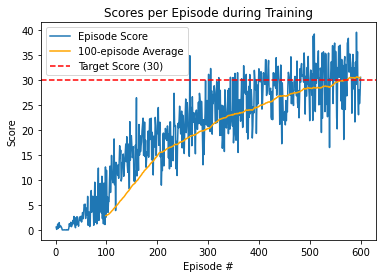

In [9]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(all_scores)+1), all_scores, label='Episode Score')
# Add a 100-episode moving average
rolling_mean = pd.Series(all_scores).rolling(avg_score_over_k_episodes).mean()
plt.plot(rolling_mean, label='100-episode Average', color='orange')
plt.axhline(y=30, color='r', linestyle='--', label='Target Score (30)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Scores per Episode during Training')
plt.legend()
plt.show()

## 4. Ideas for Future Work

While the DDPG agent successfully solved the environment, there are several avenues for future improvement and exploration:

1.  **Algorithm Enhancements**:
    *   **Twin Delayed DDPG (TD3)**: Implement TD3, which is an extension of DDPG that addresses the overestimation bias of the critic by using two critic networks and taking the minimum of their Q-values. This often leads to more stable training and better performance.
    *   **Prioritized Experience Replay (PER)**: Instead of uniform sampling from the replay buffer, use PER to sample experiences that the agent found most surprising or had the highest error. This can make learning more efficient.
    *   **Proximal Policy Optimization (PPO)**: Explore other algorithms designed for continuous control, such as PPO, which is known for its stability and ease of implementation.

2.  **Hyperparameter Tuning**:
    *   A more systematic approach to hyperparameter tuning, such as Grid Search or Bayesian Optimization, could yield a combination of parameters that allows the agent to learn faster or achieve a higher final score.

3.  **Network Architecture**:
    *   Experiment with different neural network architectures for the actor and critic. Adding or removing layers, changing the number of units per layer, or incorporating techniques like Batch Normalization could improve learning dynamics.

4.  **Exploration Strategy**:
    *   The Ornstein-Uhlenbeck process worked well, but other exploration strategies could be tested. For instance, using parameter space noise, where noise is added directly to the actor's weights, can sometimes lead to more consistent exploration.

## Inference

In [ ]:
# --- NOTE ---
# You may need to restart the kernel and re-run the environment setup cell
# before executing the inference code below.

from unityagents import UnityEnvironment
import torch, os
import numpy as np
from ddpg_agent import Agent

# Re-initialize environment
path = os.path.join(os.getcwd(), "Reacher.app")
env = UnityEnvironment(file_name=path)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]

# Get environment parameters
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
num_agents = len(env_info.agents)

# Initialize a new agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)

# Load the trained weights
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

scores = np.zeros(num_agents)
while True:
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    if np.any(dones):
        break

print('Total score this episode: {}'.format(np.mean(scores)))

env.close()